In [11]:
import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [12]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [14]:
import torch

def read_tensor_data(edge_index_path, edge_weight_path):
    edge_index = torch.load(edge_index_path)
    edge_weight = torch.load(edge_weight_path)
    G = nx.Graph()
    edge_set = set()
    count = 0
    for i in range(edge_index.size(1)):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        weight = edge_weight[i].item()
        
        # if weight is equal to 1, rescale it to 5 x 10^-5
        if weight == 1:
            weight = 5 * 10**-5
        
        # Check if the edge already exists in the set
        if (src, dst) in edge_set:
            # Update the weight of the existing edge with the larger weight value
            G[src][dst]["weight"] = max(G[src][dst]["weight"], weight)
            count += 1
            if count % 1000 == 0:
                print(f"source: {src}, destination: {dst}, weight: {weight}")
        else:
            # Add the edge to the graph and the set
            G.add_edge(src, dst, weight=weight)
            edge_set.add((src, dst))
    return G

In [25]:
# read the tensors data/edge_index.pt and data/edge_weight.pt into a networkx graph
G = read_tensor_data("../data/edge_index.pt", "../data/edge_weight.pt")

source: 674.0, destination: 22854.0, weight: 5e-05
source: 1583.0, destination: 20234.0, weight: 5e-05
source: 2437.0, destination: 24580.0, weight: 5e-05
source: 3498.0, destination: 20691.0, weight: 5e-05
source: 3764.0, destination: 19684.0, weight: 5e-05
source: 4145.0, destination: 29418.0, weight: 5e-05
source: 15440.0, destination: 21815.0, weight: 5e-05
source: 5448.0, destination: 21246.0, weight: 5e-05
source: 6056.0, destination: 21154.0, weight: 5e-05
source: 6063.0, destination: 19970.0, weight: 5e-05
source: 6385.0, destination: 21244.0, weight: 5e-05
source: 6681.0, destination: 20650.0, weight: 5e-05
source: 7047.0, destination: 21195.0, weight: 5e-05
source: 7685.0, destination: 22695.0, weight: 5e-05
source: 8293.0, destination: 21292.0, weight: 5e-05
source: 8811.0, destination: 20523.0, weight: 5e-05
source: 15710.0, destination: 21205.0, weight: 5e-05
source: 10205.0, destination: 23404.0, weight: 5e-05
source: 10687.0, destination: 19685.0, weight: 5e-05
source: 1

In [16]:
# print the number of nodes and edges in the networkx graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 51681
Number of edges: 12283287
Average degree: 475.3502


In [26]:
# create a StellarGraph object from the networkx graph
G = StellarGraph.from_networkx(G)

In [27]:
print(G.info())
print(type(G))

StellarGraph: Undirected multigraph
 Nodes: 51681, Edges: 12283287

 Node types:
  default: [51681]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [12283287]
        Weights: range=[1.1e-09, 0.041], mean=4.5758e-05, std=0.000151352
        Features: none
<class 'stellargraph.core.graph.StellarGraph'>


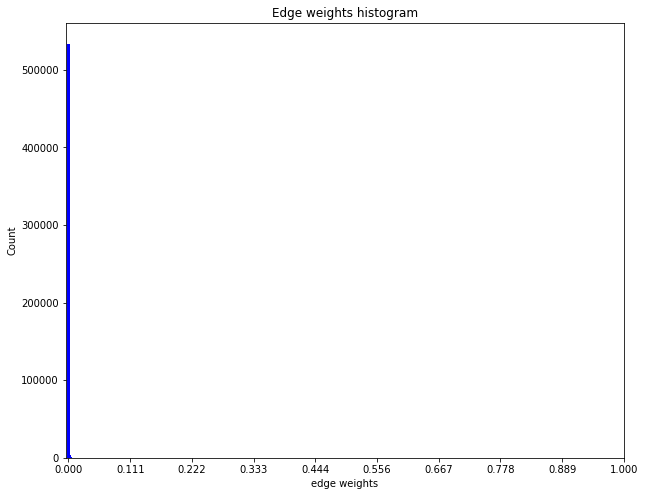

In [30]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [31]:
rw = BiasedRandomWalk(G)

In [32]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

KeyboardInterrupt: 

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1, epochs=1
)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
emb = weighted_model.wv["19231"]
emb.shape

In [ ]:
emb

In [ ]:
# save all embeddings into a file
weighted_model.wv.save_word2vec_format("../data/node_embeddings.txt")